# Predicting Post-Recovery Survival Duration in Breast Cancer Patients Using Deep Learning

## Importing Libraries

In [1]:
import pandas as pd
import torch
import random
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv("Breast_Cancer.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital_Status          4024 non-null   object
 3   T_Stage                 4024 non-null   object
 4   N_Stage                 4024 non-null   object
 5   6th_Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A_Stage                 4024 non-null   object
 9   Tumor_Size              4024 non-null   int64 
 10  Estrogen_Status         4024 non-null   object
 11  Progesterone_Status     4024 non-null   object
 12  Regional_Node_Examined  4024 non-null   int64 
 13  Reginol_Node_Positive   4024 non-null   int64 
 14  Survival_Months         4024 non-null   int64 
 15  Stat

## Creating training and validation sests

In [3]:
validation_indices = random.sample(range(len(df)), 24)
validation_set = df.iloc[validation_indices]

train_set = df.drop(validation_indices)

validation_set.to_csv('validation_set.csv', index=False)

train_set.to_csv('training_set.csv', index=False)

print("Training set size:", len(train_set))
print("Validation set size:", len(validation_set))

Training set size: 4000
Validation set size: 24


## Exploratory Data Analysis

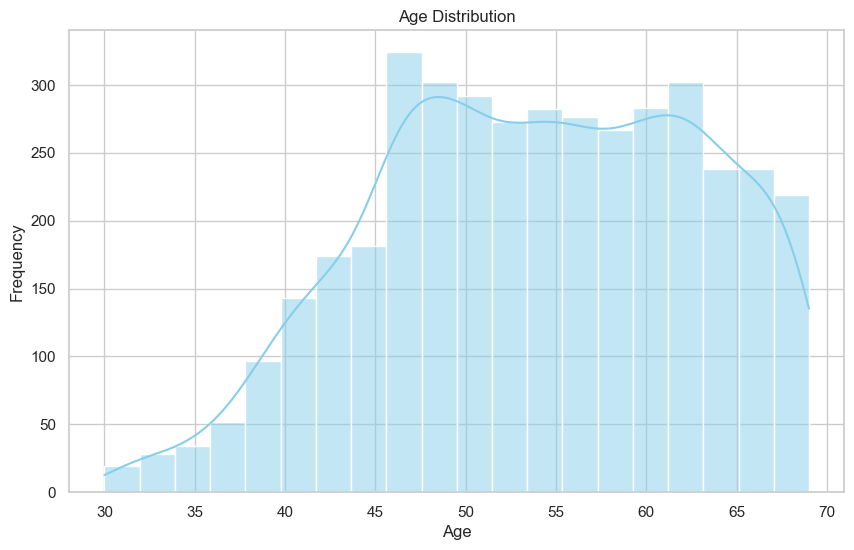

In [4]:
file_path=r'training_set.csv'
train_data = pd.read_csv(file_path)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', bins=20, kde=True, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

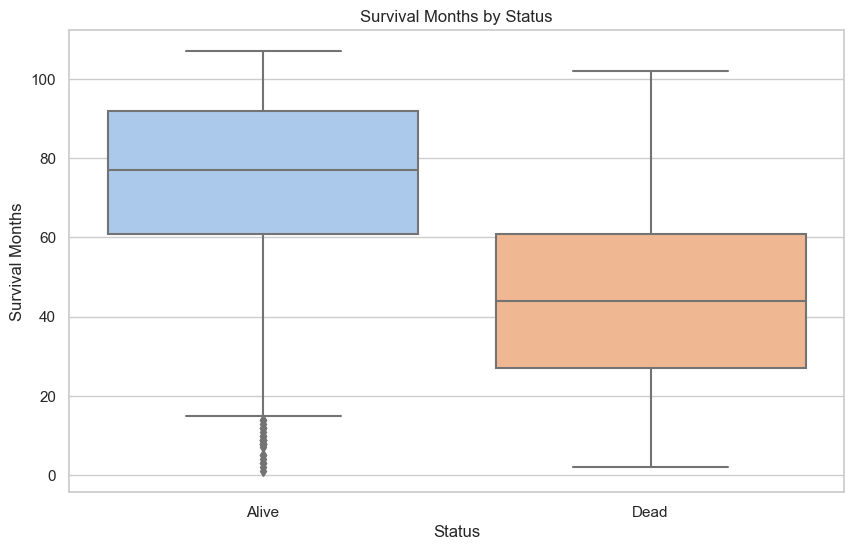

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Status', y='Survival_Months', palette='pastel')
plt.title('Survival Months by Status')
plt.xlabel('Status')
plt.ylabel('Survival Months')
plt.show()

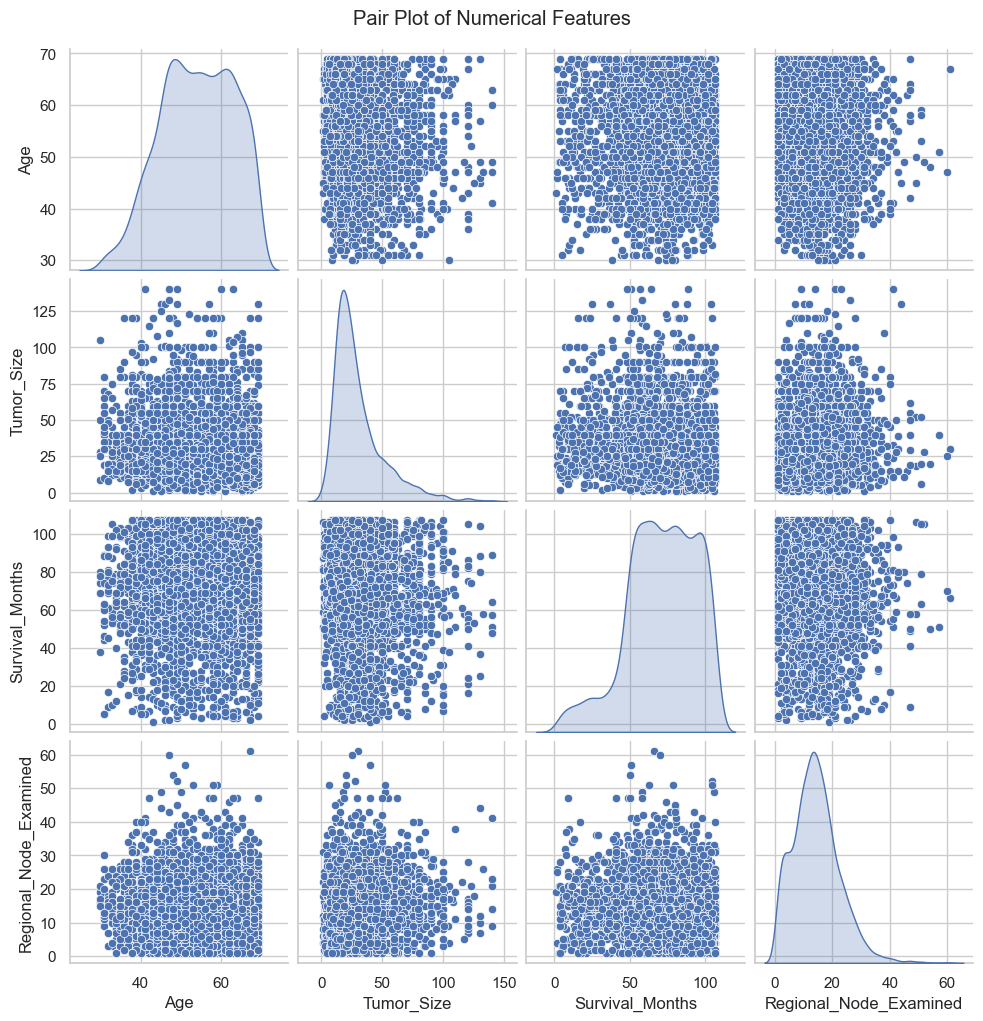

In [6]:
sns.pairplot(df[['Age', 'Tumor_Size', 'Survival_Months', 'Regional_Node_Examined']], diag_kind='kde', kind='scatter', palette='pastel')
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

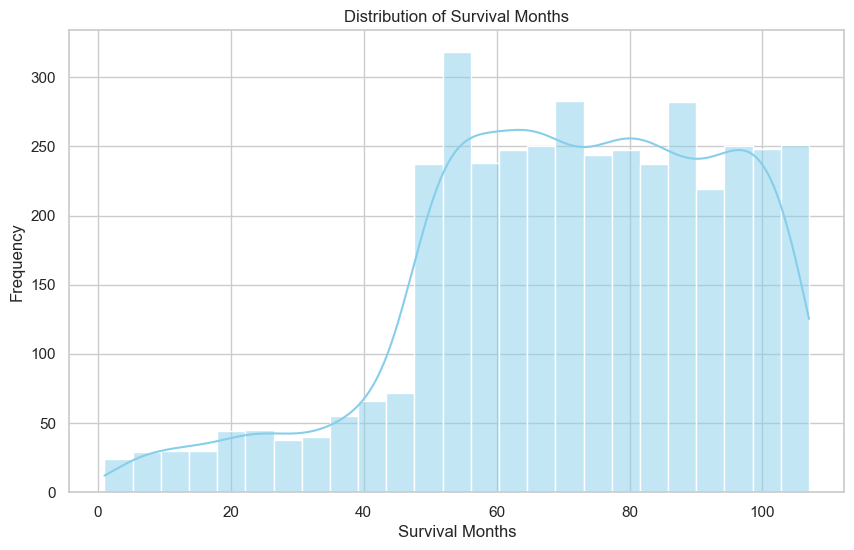

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Survival_Months'], kde=True, color='skyblue')
plt.title('Distribution of Survival Months')
plt.xlabel('Survival Months')
plt.ylabel('Frequency')
plt.show()

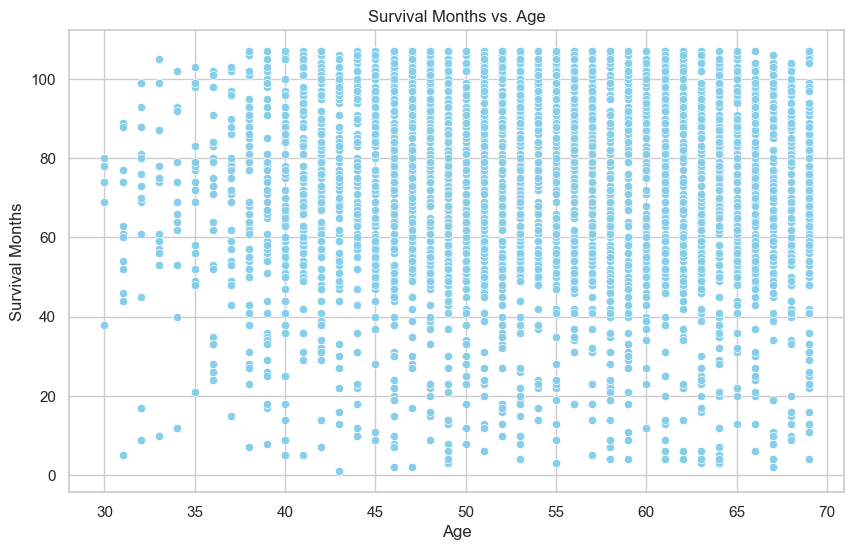

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='Survival_Months', color='skyblue')
plt.title('Survival Months vs. Age')
plt.xlabel('Age')
plt.ylabel('Survival Months')
plt.show()

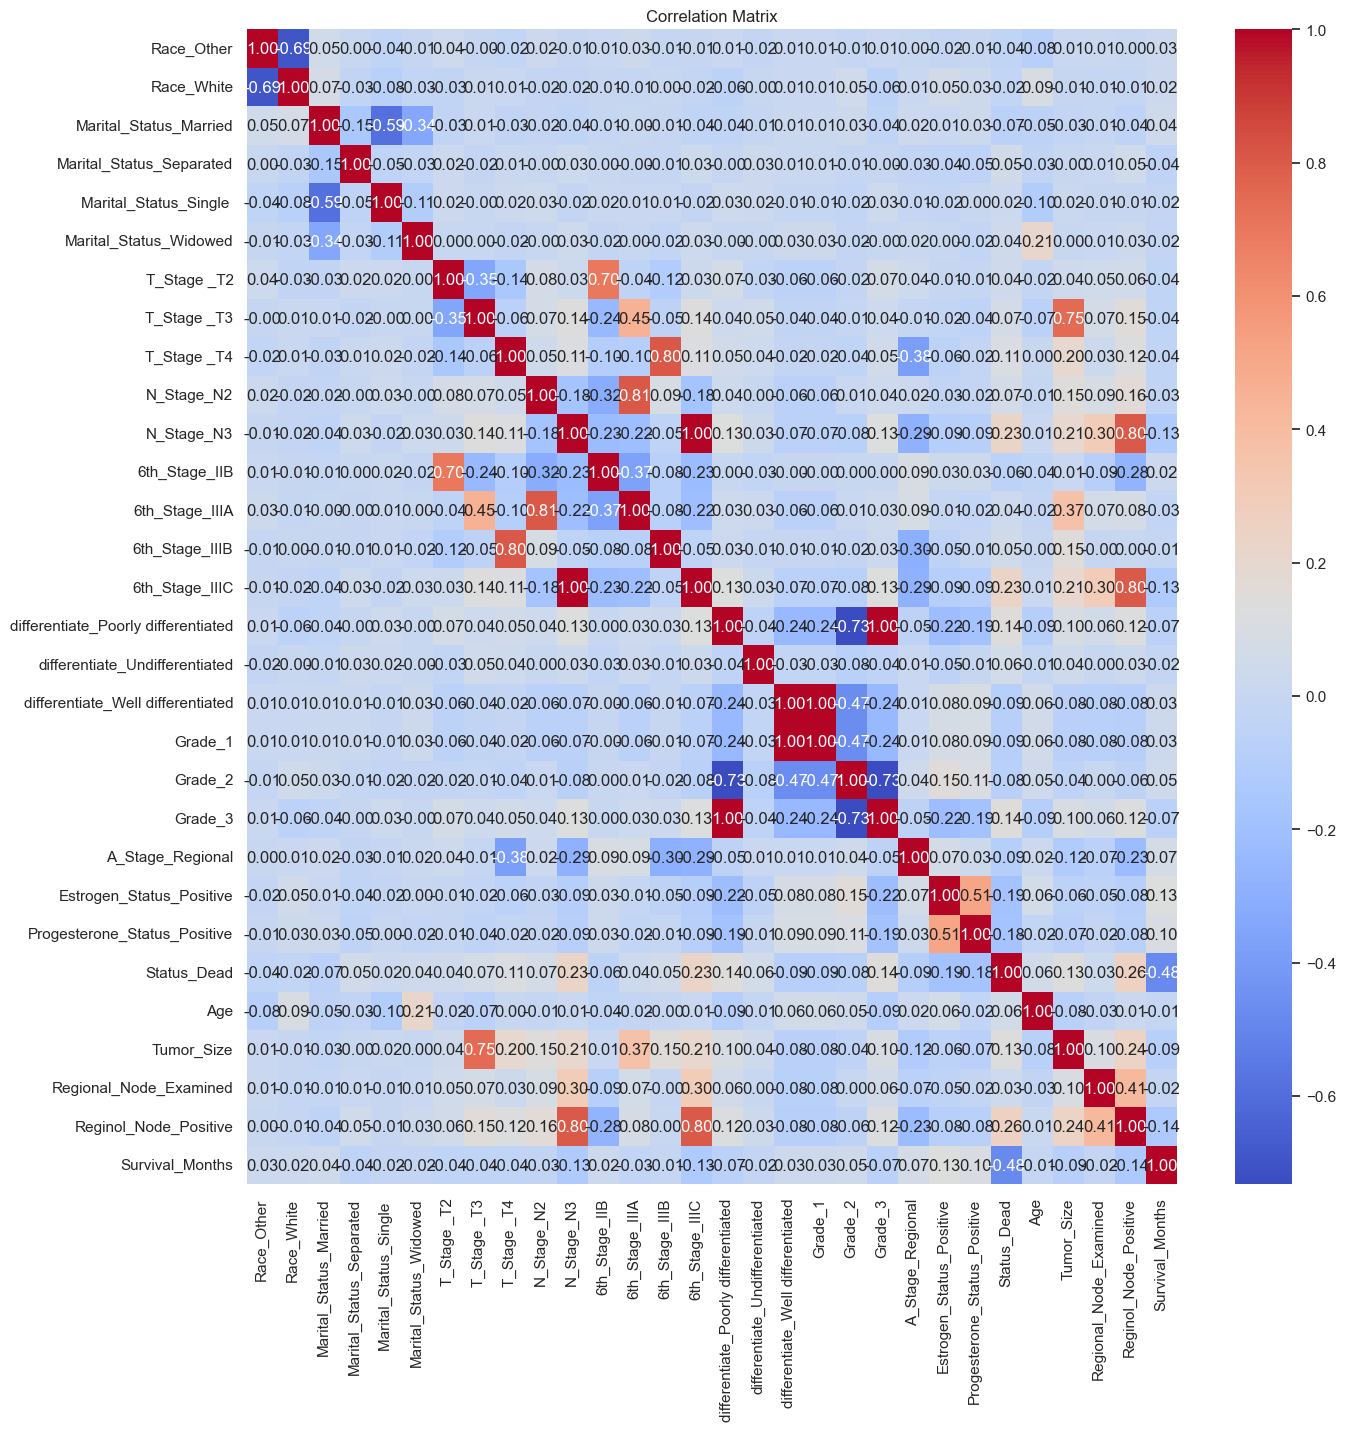

In [9]:
categorical_vars = ['Race', 'Marital_Status', 'T_Stage ', 'N_Stage', '6th_Stage', 'differentiate', 'Grade', 'A_Stage',
                    'Estrogen_Status', 'Progesterone_Status', 'Status']
numerical_vars = ['Age', 'Tumor_Size', 'Regional_Node_Examined', 'Reginol_Node_Positive', 'Survival_Months']

encoded_df = pd.get_dummies(train_data[categorical_vars], drop_first=True)

processed_data = pd.concat([encoded_df, train_data[numerical_vars]], axis=1)

corr_matrix = processed_data.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [10]:
data = pd.read_csv("Breast_Cancer.csv").drop('Status', axis=1)
train_set = train_set.drop('Status', axis=1)
validation_set = validation_set.drop('Status', axis=1)

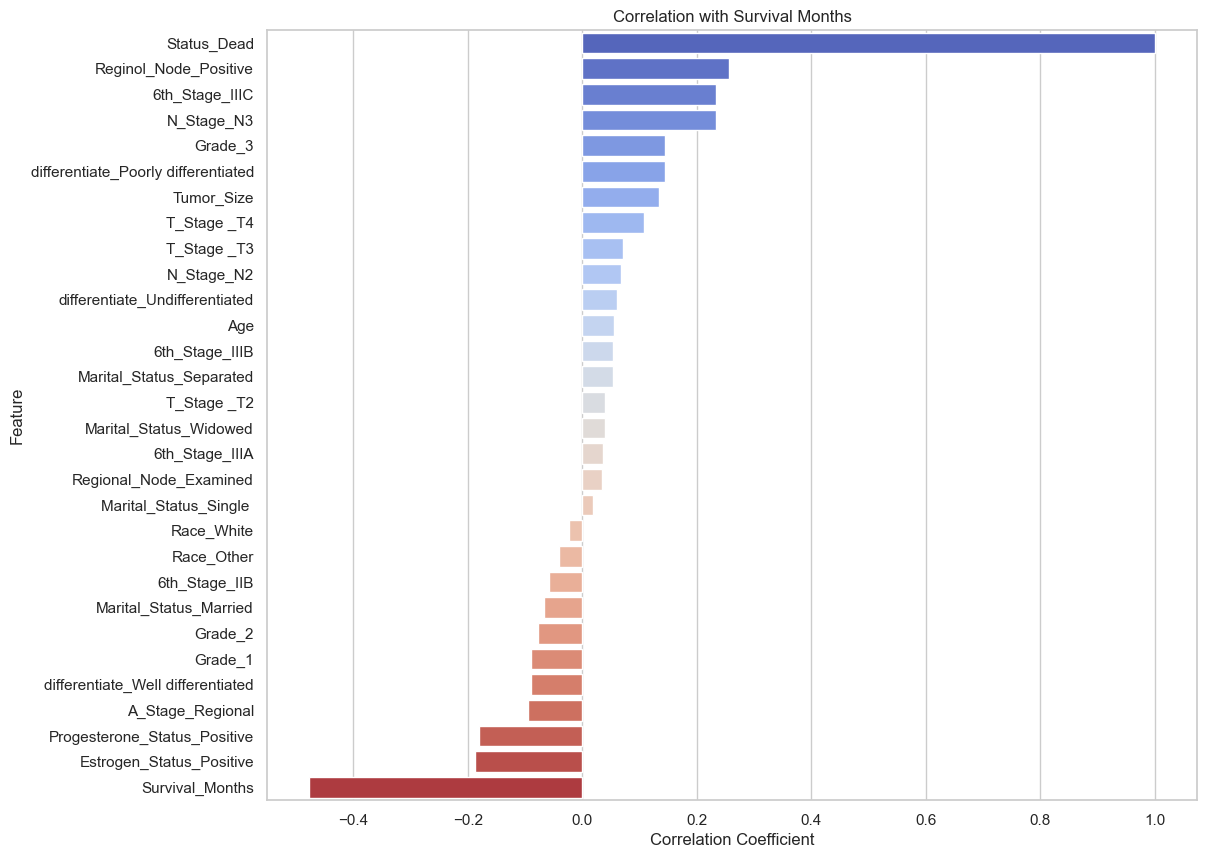

In [11]:
corr_with_survival = processed_data.corr()['Status_Dead'].sort_values(ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x=corr_with_survival.values, y=corr_with_survival.index, palette='coolwarm')
plt.title('Correlation with Survival Months')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.show()


## Encoding & Scaling Features

In [12]:
encoders = {}
for col in train_set.columns:
    if train_set[col].dtype == 'object':
        encoders[col] = LabelEncoder()
        train_set[col] = encoders[col].fit_transform(train_set[col])

scaler = StandardScaler()
numerical_cols = ['Age', 'Tumor_Size', 'Regional_Node_Examined', 'Reginol_Node_Positive']
train_set[numerical_cols] = scaler.fit_transform(train_set[numerical_cols])

scaler2 = StandardScaler()
numerical_cols2 = ['Survival_Months']
train_set[numerical_cols2] = scaler2.fit_transform(train_set[numerical_cols2])

## Data Loader

In [13]:
class BreastCancerDataset(Dataset):
    def __init__(self, data, target_col):
        self.X = torch.tensor(data.drop(target_col, axis=1).values, dtype=torch.float32)
        self.y = torch.tensor(data[target_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

target_col = 'Survival_Months'
dataset = BreastCancerDataset(train_set, target_col)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True)

## Creating a Neural Network

In [14]:
class SurvivalNet(nn.Module):
    def __init__(self, input_size):
        super(SurvivalNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

input_size = len(data.columns) - 1
model = SurvivalNet(input_size).to(device)

## Training Loop

In [15]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1500
for epoch in range(epochs):
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}:", end=" ")

        running_loss = 0.0
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            running_loss += loss.item()

        average_loss = running_loss / len(dataloader)
        print(f"Loss: {average_loss:.4f}")

    else:
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


Epoch 100: Loss: 1.0268
Epoch 200: Loss: 1.0269
Epoch 300: Loss: 1.0269
Epoch 400: Loss: 1.0268
Epoch 500: Loss: 1.0268
Epoch 600: Loss: 1.0269
Epoch 700: Loss: 1.0268
Epoch 800: Loss: 1.0269
Epoch 900: Loss: 1.0268
Epoch 1000: Loss: 1.0268
Epoch 1100: Loss: 1.0269
Epoch 1200: Loss: 1.0268
Epoch 1300: Loss: 1.0268
Epoch 1400: Loss: 1.0267
Epoch 1500: Loss: 1.0268


## Perfomance Metrics

In [16]:
def evaluate(model, test_dataset):
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in test_dataset:
            X = X.to(device)
            y_true.append(y.item())
            y_pred.append(model(X).item())

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-Squared:", r2)

evaluate(model, test_dataset)


Mean Absolute Error (MAE): 0.7596210507876822
Mean Squared Error (MSE): 0.8911164240906948
Root Mean Squared Error (RMSE): 0.9439896313470264
R-Squared: 0.0014469531422955928


## Hard coded testcase

In [55]:
def predict(model, test_case):
    with torch.no_grad():
        test_case_tensor = torch.tensor(test_case, dtype=torch.float32).to(device)
        output = model(test_case_tensor)
        return output.item()

test_case = [56, 1, 2, 1, 2, 1, 2, 1, 1, 20, 1, 1, 12, 8]

predicted_survival_months = predict(model, test_case)
print("Predicted survival months:", predicted_survival_months)


Predicted survival months: -1.6348618268966675


In [56]:
predicted_survival_months_scaled = predicted_survival_months
predicted_survival_months1 = scaler2.inverse_transform(np.array([[predicted_survival_months_scaled]]))[0][0]
print("Predicted survival months:", predicted_survival_months1)

Predicted survival months: 33.81648914149776


## Label Encoding Mappings

In [19]:
print("Label Encoding Mappings:")
for col, encoder in encoders.items():
    print(f"Column: {col}")
    print("Original Values:", encoder.classes_)
    print("Encoded Values:", list(range(len(encoder.classes_))))
    print()

Label Encoding Mappings:
Column: Race
Original Values: ['Black' 'Other' 'White']
Encoded Values: [0, 1, 2]

Column: Marital_Status
Original Values: ['Divorced' 'Married' 'Separated' 'Single ' 'Widowed']
Encoded Values: [0, 1, 2, 3, 4]

Column: T_Stage 
Original Values: ['T1' 'T2' 'T3' 'T4']
Encoded Values: [0, 1, 2, 3]

Column: N_Stage
Original Values: ['N1' 'N2' 'N3']
Encoded Values: [0, 1, 2]

Column: 6th_Stage
Original Values: ['IIA' 'IIB' 'IIIA' 'IIIB' 'IIIC']
Encoded Values: [0, 1, 2, 3, 4]

Column: differentiate
Original Values: ['Moderately differentiated' 'Poorly differentiated' 'Undifferentiated'
 'Well differentiated']
Encoded Values: [0, 1, 2, 3]

Column: Grade
Original Values: [' anaplastic; Grade IV' '1' '2' '3']
Encoded Values: [0, 1, 2, 3]

Column: A_Stage
Original Values: ['Distant' 'Regional']
Encoded Values: [0, 1]

Column: Estrogen_Status
Original Values: ['Negative' 'Positive']
Encoded Values: [0, 1]

Column: Progesterone_Status
Original Values: ['Negative' 'Positiv

## User Input Testing

In [57]:
def create_formatted_list(features):

    result_list = []
    for i, description in enumerate(features):
        while True:
            try:
                value = int(input(f"Enter value for {description}): "))
                result_list.append(value)
                break 
            except ValueError:
                print("Invalid input. Please enter an integer.")

    return result_list


# Example usage
features = ["Age", "Race: 'Black 0' 'Other 1' 'White 2'", "Marital Status: 'Divorced 0' 'Married 1' 'Separated 2' 'Single 3' 'Widowed 4'", "T stage: 'T1 0' 'T2 1' 'T3 2' 'T4 3'", "N stage: 'N1 0' 'N2 1' 'N3 2'", "6th stage: 'IIA 0' 'IIB 1' 'IIIA 2' 'IIIB 3' 'IIIC 4'", "Differentiate: 'Moderately differentiated 0' 'Poorly differentiated 1' 'Undifferentiated 2','Well differentiated 3'", "Grade", "A stage: 'Distant 0' 'Regional 1'", "Tumor size", "Estrogen status: 'Negative 0' 'Positive 1'", "Progesterone Status: 'Negative 0' 'Positive 1'", "Regional nodes examined", "Regional nodes positive"]
test_case_user = create_formatted_list(features)

predicted_survival_months_user = predict(model, test_case_user)
print("Predicted survival months:", predicted_survival_months_user)


Enter value for Age):  52
Enter value for Race: 'Black 0' 'Other 1' 'White 2'):  2
Enter value for Marital Status: 'Divorced 0' 'Married 1' 'Separated 2' 'Single 3' 'Widowed 4'):  1
Enter value for T stage: 'T1 0' 'T2 1' 'T3 2' 'T4 3'):  3
Enter value for N stage: 'N1 0' 'N2 1' 'N3 2'):  0
Enter value for 6th stage: 'IIA 0' 'IIB 1' 'IIIA 2' 'IIIB 3' 'IIIC 4'):  3
Enter value for Differentiate: 'Moderately differentiated 0' 'Poorly differentiated 1' 'Undifferentiated 2','Well differentiated 3'):  0
Enter value for Grade):  2
Enter value for A stage: 'Distant 0' 'Regional 1'):  1
Enter value for Tumor size):  40
Enter value for Estrogen status: 'Negative 0' 'Positive 1'):  1
Enter value for Progesterone Status: 'Negative 0' 'Positive 1'):  1
Enter value for Regional nodes examined):  7
Enter value for Regional nodes positive):  3


Predicted survival months: -1.1797257661819458


In [58]:
predicted_survival_months_user_scaled = predicted_survival_months_user
predicted_survival_months_user1 = scaler2.inverse_transform(np.array([[predicted_survival_months_user_scaled]]))[0][0]
print("Predicted survival months:", predicted_survival_months_user1)

Predicted survival months: 44.24437354850214
